In [1]:

%pprint
import sys
sys.path.insert(1, '../py')

Pretty printing has been turned OFF


In [2]:

import os
from pandas import DataFrame
import pandas as pd
from notebook_utils import NotebookUtilities
import matplotlib.pyplot as plt
import re

nu = NotebookUtilities(data_folder_path=os.path.abspath('../data'))


# Elapsed Time Estimation for Operations

In [3]:

# Get all CSVs into one data frame
if nu.pickle_exists('clean_csvs_df'):
    clean_csvs_df = nu.load_object('clean_csvs_df')
    print(clean_csvs_df.shape)
    df = clean_csvs_df.sample(4).dropna(axis='columns', how='all')
    display(df.T)

(149166, 101)


,114528,109470,130871,56889
action_type,TAG_SELECTED,VOICE_CAPTURE,PULSE_TAKEN,TOOL_HOVER
elapsed_time,492599,209007,342500,133130
event_time,2023-05-10 10:32:00,2023-05-11 10:22:00,2023-04-21 09:33:00,2023-05-11 09:55:00
session_uuid,d06f4054-097a-46ef-a88e-69665bf42389,c12f8355-5a14-4ccc-bde4-d8038cae9220,87efcdf5-9090-4fa5-afac-25c778924e9a,25309ebf-8ca2-4678-af43-2d4030eb1c5d
file_name,d06f4054-097a-46ef-a88e-69665bf42389,c12f8355-5a14-4ccc-bde4-d8038cae9220,max10,25309ebf-8ca2-4678-af43-2d4030eb1c5d
time_group,2,1,2,1
voice_capture_message,NaN,alright so Jess is gonna get this started,NaN,NaN
pulse_taken_pulse_name,NaN,NaN,pulse_none,NaN
pulse_taken_patient_id,NaN,NaN,Bob_0 Root,NaN
tool_hover_type,NaN,NaN,NaN,Needle



## Operations

Here are the operations for which we could use a better estimate for elapsed time that we can use for ADM actions:

- apply tourniquet
- apply pressure bandage
- apply hemostatic gauze
- apply decompression needle
- apply nasopharyngeal airway
- tag a casualty
- check pulse
- direct mobile casualties (walkers check)
- wavers check.

In [4]:

# List the action types
clean_csvs_df.action_type.value_counts().sort_index()

action_type
BAG_ACCESS              2180
BAG_CLOSED              2149
INJURY_RECORD           3052
INJURY_TREATED          1577
PATIENT_DEMOTED         1818
PATIENT_ENGAGED         2295
PATIENT_RECORD          2063
PULSE_TAKEN             3427
SESSION_END              256
SESSION_START            266
S_A_L_T_WALKED          2725
S_A_L_T_WALK_IF_CAN     4567
S_A_L_T_WAVED           1761
S_A_L_T_WAVE_IF_CAN     2147
TAG_APPLIED             1819
TAG_DISCARDED            533
TAG_SELECTED            2353
TELEPORT                5678
TOOL_APPLIED            1818
TOOL_DISCARDED          1655
TOOL_HOVER             89733
TOOL_SELECTED           2263
VOICE_CAPTURE          10115
VOICE_COMMAND           2916
Name: count, dtype: int64

In [5]:

clean_csvs_df.tool_applied_type.unique().tolist()

[nan, 'Needle', 'Tourniquet', 'Gauze_Pack', 'Gauze_Dressing']


These action types mean that the DM has made a decision: INJURY_TREATED, PATIENT_ENGAGED, PULSE_TAKEN, TAG_APPLIED, and TOOL_APPLIED.

In [6]:

def get_session_groupby(mask_series=None, extra_column=None):
    if (mask_series is None) and (extra_column is None):
        gb = clean_csvs_df.sort_values(['elapsed_time']).groupby(['session_uuid'])
    elif (mask_series is None) and (extra_column is not None):
        gb = clean_csvs_df.sort_values(['elapsed_time']).groupby(['session_uuid', extra_column])
    elif (mask_series is not None) and (extra_column is None):
        gb = clean_csvs_df[mask_series].sort_values(['elapsed_time']).groupby(['session_uuid'])
    elif (mask_series is not None) and (extra_column is not None):
        gb = clean_csvs_df[mask_series].sort_values(['elapsed_time']).groupby(['session_uuid', extra_column])

    return gb

In [7]:

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import numpy as np

In [8]:

# Apply some tool
def show_action_consequents(tool_mask_series, action_type='TOOL_APPLIED', voice_command_message=None, verbose=False):
    """
    Show the consequents of the given action type.

    Parameters
    ----------
    tool_mask_series : Series
        The type of filter to apply to get_session_groupby.
    action_type : str, optional
        The type of action to consider. Defaults to 'TOOL_APPLIED'.
    voice_command_message : str, optional
        The specific voice command. Defaults to None.

    Returns
    -------
    None

    """
    
    actions_list = []
    for (session_uuid, time_group), df in get_session_groupby(mask_series=tool_mask_series, extra_column='time_group'):
        base_mask_series = (clean_csvs_df.session_uuid == session_uuid) & (clean_csvs_df.time_group == time_group)
        for row_index, row_series in df.iterrows():
            elapsed_time = row_series.elapsed_time
            mask_series = base_mask_series & (clean_csvs_df.elapsed_time >= elapsed_time)
            df1 = clean_csvs_df[mask_series].sort_values('elapsed_time')
            
            # Get the list of actions that follow the given action type
            action_types_list = []
            if df1.shape[0] > 1:
                action_types_list = df1.action_type.tolist()
                if 'INJURY_TREATED' in action_types_list: action_types_list = action_types_list[:min(7, action_types_list.index('INJURY_TREATED')+1)]
                else: action_types_list = action_types_list[:2]
            if action_types_list: actions_list.append(action_types_list)
            
            # Get the delta to the next action not happening simultaneously
            mask_series = base_mask_series & (clean_csvs_df.elapsed_time > elapsed_time)
            if (action_type == 'VOICE_COMMAND') and (voice_command_message is not None):
                walk_wave = (voice_command_message.split(' ')[0] + 'ed').replace('ee', 'e')
                mask_series &= clean_csvs_df.action_type.map(lambda x: walk_wave in str(x).lower())
                # print(f"mask_series = (clean_csvs_df.session_uuid == '{session_uuid}') & (clean_csvs_df.time_group == {time_group}) & (clean_csvs_df.elapsed_time > {elapsed_time}) & clean_csvs_df.action_type.map(lambda x: '{walk_wave}' in str(x).lower())"); raise
            df1 = clean_csvs_df[mask_series].sort_values('elapsed_time').head(1)
            if df1.shape[0]:
                clean_csvs_df.loc[row_index, 'delta_to_next_action'] = (df1.elapsed_time.squeeze() - elapsed_time)
            else:
                clean_csvs_df.loc[row_index, 'delta_to_next_action'] = np.nan
            
    if actions_list:
        
        # Create a one-hot encoded DataFrame of the actions
        te = TransactionEncoder()
        te_ary = te.fit(actions_list).transform(actions_list)
        actions_one_hot_df = DataFrame(te_ary, columns=te.columns_)
        
        # Print the actions following the given action type
        print(f'The actions following {action_type} are {nu.conjunctify_nouns(actions_one_hot_df.columns.tolist())}.')
        
        # Get the frequent itemsets and association rules
        actions_itemsets_df = apriori(
            actions_one_hot_df, min_support=0.01, use_colnames=True, max_len=50
        )
        actions_itemsets_df['itemsets_size'] = actions_itemsets_df.itemsets.map(lambda x: len(eval(str(x))))
        
        actions_rules_df = association_rules(actions_itemsets_df, metric='lift', min_threshold=0.75)
        
        # Get the consequents with the highest support for the given action type
        mask_series = (actions_rules_df.antecedents == frozenset({action_type}))
        df = actions_rules_df[mask_series].sort_values(['lift', 'consequent support'], ascending=[False, False])
        if df.head(5).shape[0]:
            print(f'Get the consequent with the highest support for {action_type.lower().replace("_", " ")}')
            display(df.head(5))

In [9]:

# Apply tourniquet
tool_mask_series = (clean_csvs_df.action_type == 'TOOL_APPLIED') & (clean_csvs_df.tool_applied_type == 'Tourniquet')
show_action_consequents(tool_mask_series)

The actions following TOOL_APPLIED are BAG_ACCESS, BAG_CLOSED, INJURY_TREATED, PATIENT_ENGAGED, PULSE_TAKEN, S_A_L_T_WALKED, S_A_L_T_WALK_IF_CAN, TAG_APPLIED, TAG_DISCARDED, TAG_SELECTED, TELEPORT, TOOL_APPLIED, TOOL_DISCARDED, TOOL_HOVER, TOOL_SELECTED, VOICE_CAPTURE, and VOICE_COMMAND.
Get the consequent with the highest support for tool applied


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
73,(TOOL_APPLIED),(VOICE_CAPTURE),0.255692,0.098074,0.098074,0.383562,3.910959,0.072997,1.463125,1.0
57,(TOOL_APPLIED),(TAG_SELECTED),0.255692,0.094571,0.094571,0.369863,3.910959,0.070390,1.436877,1.0
36,(TOOL_APPLIED),(PULSE_TAKEN),0.255692,0.084063,0.084063,0.328767,3.910959,0.062569,1.364559,1.0
18,(TOOL_APPLIED),(BAG_CLOSED),0.255692,0.070053,0.070053,0.273973,3.910959,0.052141,1.280871,1.0
47,(TOOL_APPLIED),(TAG_APPLIED),0.255692,0.061296,0.061296,0.239726,3.910959,0.045623,1.234692,1.0


In [10]:

# apply pressure bandage
tool_mask_series = (clean_csvs_df.action_type == 'TOOL_APPLIED') & (clean_csvs_df.tool_applied_type == 'Gauze_Dressing')
show_action_consequents(tool_mask_series)

The actions following TOOL_APPLIED are BAG_ACCESS, BAG_CLOSED, INJURY_TREATED, PATIENT_ENGAGED, PULSE_TAKEN, TAG_APPLIED, TAG_DISCARDED, TAG_SELECTED, TELEPORT, TOOL_APPLIED, TOOL_DISCARDED, TOOL_HOVER, TOOL_SELECTED, VOICE_CAPTURE, and VOICE_COMMAND.
Get the consequent with the highest support for tool applied


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
63,(TOOL_APPLIED),(TAG_SELECTED),0.371316,0.094303,0.094303,0.253968,2.693122,0.059286,1.214020,1.0
81,(TOOL_APPLIED),(VOICE_CAPTURE),0.371316,0.082515,0.082515,0.222222,2.693122,0.051876,1.179624,1.0
20,(TOOL_APPLIED),(BAG_CLOSED),0.371316,0.076621,0.076621,0.206349,2.693122,0.048170,1.163458,1.0
46,(TOOL_APPLIED),(PULSE_TAKEN),0.371316,0.076621,0.076621,0.206349,2.693122,0.048170,1.163458,1.0
69,(TOOL_APPLIED),(TELEPORT),0.371316,0.074656,0.074656,0.201058,2.693122,0.046935,1.158212,1.0


In [11]:

# apply hemostatic gauze
tool_mask_series = (clean_csvs_df.action_type == 'TOOL_APPLIED') & (clean_csvs_df.tool_applied_type == 'Gauze_Pack')
show_action_consequents(tool_mask_series)

The actions following TOOL_APPLIED are BAG_ACCESS, BAG_CLOSED, INJURY_TREATED, PATIENT_ENGAGED, PULSE_TAKEN, S_A_L_T_WAVED, S_A_L_T_WAVE_IF_CAN, TAG_APPLIED, TAG_DISCARDED, TAG_SELECTED, TELEPORT, TOOL_APPLIED, TOOL_DISCARDED, TOOL_HOVER, TOOL_SELECTED, VOICE_CAPTURE, and VOICE_COMMAND.
Get the consequent with the highest support for tool applied


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
63,(TOOL_APPLIED),(VOICE_CAPTURE),0.208247,0.080412,0.080412,0.386139,4.80198,0.063667,1.498038,1.0
53,(TOOL_APPLIED),(TAG_SELECTED),0.208247,0.049485,0.049485,0.237624,4.80198,0.039180,1.246780,1.0
28,(TOOL_APPLIED),(PULSE_TAKEN),0.208247,0.047423,0.047423,0.227723,4.80198,0.037547,1.233466,1.0
14,(TOOL_APPLIED),(BAG_CLOSED),0.208247,0.037113,0.037113,0.178218,4.80198,0.029385,1.171705,1.0
41,(TOOL_APPLIED),(TAG_APPLIED),0.208247,0.037113,0.037113,0.178218,4.80198,0.029385,1.171705,1.0


In [12]:

# apply decompression needle
tool_mask_series = (clean_csvs_df.action_type == 'TOOL_APPLIED') & (clean_csvs_df.tool_applied_type == 'Needle')
show_action_consequents(tool_mask_series)

The actions following TOOL_APPLIED are BAG_ACCESS, BAG_CLOSED, INJURY_TREATED, PATIENT_ENGAGED, PULSE_TAKEN, S_A_L_T_WALK_IF_CAN, TAG_APPLIED, TAG_DISCARDED, TAG_SELECTED, TELEPORT, TOOL_APPLIED, TOOL_HOVER, VOICE_CAPTURE, and VOICE_COMMAND.
Get the consequent with the highest support for tool applied


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
67,(TOOL_APPLIED),(TAG_SELECTED),0.256917,0.189723,0.189723,0.738462,3.892308,0.140980,3.098117,1.0
40,(TOOL_APPLIED),(PULSE_TAKEN),0.256917,0.130435,0.130435,0.507692,3.892308,0.096924,1.766304,1.0
18,(TOOL_APPLIED),(BAG_CLOSED),0.256917,0.118577,0.118577,0.461538,3.892308,0.088113,1.636928,1.0
467,(TOOL_APPLIED),"(TAG_SELECTED, VOICE_CAPTURE)",0.256917,0.118577,0.118577,0.461538,3.892308,0.088113,1.636928,1.0
214,(TOOL_APPLIED),"(TAG_SELECTED, BAG_CLOSED)",0.256917,0.106719,0.106719,0.415385,3.892308,0.079301,1.527980,1.0


In [13]:

# apply nasopharyngeal airway
tool_mask_series = (clean_csvs_df.action_type == 'TOOL_APPLIED') & (clean_csvs_df.tool_applied_type == 'Nasopharyngeal_Airway')
show_action_consequents(tool_mask_series)

In [14]:

# tag a casualty
action_type = 'TAG_APPLIED'
tool_mask_series = (clean_csvs_df.action_type == action_type)
show_action_consequents(tool_mask_series, action_type=action_type)

The actions following TAG_APPLIED are BAG_ACCESS, BAG_CLOSED, INJURY_TREATED, PATIENT_ENGAGED, PULSE_TAKEN, SESSION_END, S_A_L_T_WALKED, S_A_L_T_WALK_IF_CAN, S_A_L_T_WAVED, S_A_L_T_WAVE_IF_CAN, TAG_APPLIED, TAG_DISCARDED, TAG_SELECTED, TELEPORT, TOOL_APPLIED, TOOL_DISCARDED, TOOL_HOVER, TOOL_SELECTED, VOICE_CAPTURE, and VOICE_COMMAND.
Get the consequent with the highest support for tag applied


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
22,(TAG_APPLIED),(BAG_CLOSED),1.0,0.722069,0.722069,0.722069,1.0,0.0,1.0,0.0
78,(TAG_APPLIED),(TELEPORT),1.0,0.627408,0.627408,0.627408,1.0,0.0,1.0,0.0
377,(TAG_APPLIED),"(TELEPORT, BAG_CLOSED)",1.0,0.599340,0.599340,0.599340,1.0,0.0,1.0,0.0
82,(TAG_APPLIED),(VOICE_CAPTURE),1.0,0.483214,0.483214,0.483214,1.0,0.0,1.0,0.0
36,(TAG_APPLIED),(PATIENT_ENGAGED),1.0,0.472757,0.472757,0.472757,1.0,0.0,1.0,0.0


In [15]:

# check pulse
action_type = 'PULSE_TAKEN'
tool_mask_series = (clean_csvs_df.action_type == action_type)
show_action_consequents(tool_mask_series, action_type=action_type)

The actions following PULSE_TAKEN are BAG_ACCESS, BAG_CLOSED, INJURY_TREATED, PATIENT_DEMOTED, PATIENT_ENGAGED, PULSE_TAKEN, SESSION_END, S_A_L_T_WALKED, S_A_L_T_WALK_IF_CAN, S_A_L_T_WAVED, S_A_L_T_WAVE_IF_CAN, TAG_APPLIED, TAG_DISCARDED, TAG_SELECTED, TELEPORT, TOOL_APPLIED, TOOL_DISCARDED, TOOL_HOVER, TOOL_SELECTED, VOICE_CAPTURE, and VOICE_COMMAND.
Get the consequent with the highest support for pulse taken


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
63,(PULSE_TAKEN),(VOICE_CAPTURE),1.0,0.509489,0.509489,0.509489,1.0,0.0,1.0,0.0
59,(PULSE_TAKEN),(TOOL_HOVER),1.0,0.390949,0.390949,0.390949,1.0,0.0,1.0,0.0
5,(PULSE_TAKEN),(BAG_ACCESS),1.0,0.348321,0.348321,0.348321,1.0,0.0,1.0,0.0
53,(PULSE_TAKEN),(TAG_SELECTED),1.0,0.275036,0.275036,0.275036,1.0,0.0,1.0,0.0
55,(PULSE_TAKEN),(TELEPORT),1.0,0.260438,0.260438,0.260438,1.0,0.0,1.0,0.0


In [16]:

# direct mobile casualties (walkers check)
# We are interested in how long it takes the medic to do things not how long it would take the patients to move.
# So in this case, first one starts moving is good (as the medic is likely still paying attention until compliance is demonstrated)
action_type = 'VOICE_COMMAND'
voice_command_message = 'walk to the safe area'
tool_mask_series = (clean_csvs_df.action_type == action_type) & (clean_csvs_df.voice_command_message == voice_command_message)
show_action_consequents(tool_mask_series, action_type=action_type, voice_command_message=voice_command_message)

The actions following VOICE_COMMAND are BAG_ACCESS, BAG_CLOSED, PATIENT_ENGAGED, PULSE_TAKEN, S_A_L_T_WALKED, S_A_L_T_WALK_IF_CAN, S_A_L_T_WAVED, S_A_L_T_WAVE_IF_CAN, TAG_DISCARDED, TAG_SELECTED, TELEPORT, TOOL_DISCARDED, TOOL_HOVER, VOICE_CAPTURE, and VOICE_COMMAND.
Get the consequent with the highest support for voice command


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
31,(VOICE_COMMAND),(TELEPORT),0.993388,0.066116,0.066116,0.066556,1.006656,0.000437,1.000471,1.0
2,(VOICE_COMMAND),(PATIENT_ENGAGED),0.993388,0.034711,0.034711,0.034942,1.006656,0.000229,1.000239,1.0
37,(VOICE_COMMAND),"(VOICE_CAPTURE, PATIENT_ENGAGED)",0.993388,0.033058,0.033058,0.033278,1.006656,0.000219,1.000228,1.0
6,(VOICE_COMMAND),(PULSE_TAKEN),0.993388,0.018182,0.018182,0.018303,1.006656,0.000120,1.000123,1.0
79,(VOICE_COMMAND),"(TELEPORT, S_A_L_T_WALK_IF_CAN)",0.993388,0.018182,0.018182,0.018303,1.006656,0.000120,1.000123,1.0


In [17]:

# wavers check
action_type = 'VOICE_COMMAND'
voice_command_message = 'wave if you can'
tool_mask_series = (clean_csvs_df.action_type == action_type) & (clean_csvs_df.voice_command_message == voice_command_message)
show_action_consequents(tool_mask_series, action_type=action_type, voice_command_message=voice_command_message)

The actions following VOICE_COMMAND are BAG_ACCESS, BAG_CLOSED, PATIENT_ENGAGED, PULSE_TAKEN, S_A_L_T_WALKED, S_A_L_T_WALK_IF_CAN, S_A_L_T_WAVED, S_A_L_T_WAVE_IF_CAN, TAG_APPLIED, TAG_SELECTED, TELEPORT, TOOL_HOVER, VOICE_CAPTURE, and VOICE_COMMAND.
Get the consequent with the highest support for voice command


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
55,(VOICE_COMMAND),(S_A_L_T_WALK_IF_CAN),0.964664,0.242049,0.242049,0.250916,1.03663,0.008553,1.011836,1.0
47,(VOICE_COMMAND),(S_A_L_T_WALKED),0.964664,0.213781,0.213781,0.221612,1.03663,0.007554,1.010060,1.0
289,(VOICE_COMMAND),"(S_A_L_T_WALKED, S_A_L_T_WALK_IF_CAN)",0.964664,0.208481,0.208481,0.216117,1.03663,0.007367,1.009742,1.0
343,(VOICE_COMMAND),"(S_A_L_T_WALK_IF_CAN, S_A_L_T_WAVE_IF_CAN)",0.964664,0.160777,0.160777,0.166667,1.03663,0.005681,1.007067,1.0
307,(VOICE_COMMAND),"(S_A_L_T_WALKED, S_A_L_T_WAVE_IF_CAN)",0.964664,0.146643,0.146643,0.152015,1.03663,0.005182,1.006334,1.0


In [18]:

# Convert the integer delta_to_next_action column into a time delta column
if (clean_csvs_df.delta_to_next_action.dtype != np.dtype('<m8[ns]')):
    clean_csvs_df.delta_to_next_action = clean_csvs_df.delta_to_next_action.map(lambda x: pd.Timedelta(value=x, unit='milliseconds'))
    nu.store_objects(clean_csvs_df=clean_csvs_df)

Pickling to C:\Users\DaveBabbitt\Documents\GitHub\notebooks\saves\pkl\clean_csvs_df.pkl



----
# Visualize the Histograms

In [20]:

from pandas import Timedelta
import humanize

mask_series = ~clean_csvs_df.delta_to_next_action.isnull()
df = clean_csvs_df[mask_series]
tuples_list = []
for i, groupby_list in enumerate(['tool_applied_type', 'voice_command_message']):
    for column_name, df1 in df.groupby(groupby_list):

        # Filter to only keep values within 1.75 * Inter quartile range
        q1 = df1.delta_to_next_action.quantile(0.25)
        q3 = df1.delta_to_next_action.quantile(0.75)
        iqr = q3 - q1
        lower_range = q1 - 1.75 * iqr
        higher_range = q3 + 1.75 * iqr
        mask_series = df1.delta_to_next_action.between(lower_range, higher_range) & ~df1.delta_to_next_action.isnull()
        df_filtered = df1[mask_series]
        
        # Calculate the numerical descriptives for tool_applied: mean, median, mode, range, and SD
        mean = humanize.precisedelta(df1.delta_to_next_action.mean())
        median = humanize.precisedelta(df1.delta_to_next_action.median())
        mode = df1.delta_to_next_action.mode().squeeze()
        if(type(mode) != Timedelta): mode = pd.NaT
        else: mode = humanize.precisedelta(mode)
        max = df1.delta_to_next_action.max()
        min = df1.delta_to_next_action.min()
        # range = humanize.precisedelta(max - min)
        max = humanize.precisedelta(max); min = humanize.precisedelta(min)
        sd = humanize.precisedelta(df1.delta_to_next_action.std())
        row_dict = {
            'tool_applied_type': column_name, 'mean': mean, 'median': median, 'mode': mode, 'max': max, 'min': min,
            # 'range': range,
            'sd': sd
        }

        # Put these all in a tuple and add them to the list
        percentiles_tuple = (df_filtered.delta_to_next_action.map(lambda td: td.total_seconds()), column_name, row_dict)
        tuples_list.append(percentiles_tuple)

In [44]:

rows_list = []
for percentiles_tuple in tuples_list:
    row_dict = percentiles_tuple[2]
    rows_list.append(row_dict)
df = DataFrame(rows_list).set_index('tool_applied_type')
df

,mean,median,mode,max,min,sd
tool_applied_type,,,,,,
Gauze_Dressing,2.83 seconds,2.11 seconds,NaT,22.42 seconds,0.01 seconds,2.56 seconds
Gauze_Pack,2.81 seconds,2.08 seconds,0.05 seconds,22.75 seconds,0.01 seconds,2.56 seconds
Needle,3.64 seconds,3.18 seconds,0.33 seconds,20.07 seconds,0.01 seconds,3.02 seconds
Tourniquet,3.12 seconds,2.23 seconds,0.05 seconds,30.81 seconds,0.00 seconds,3.31 seconds
walk to the safe area,6.96 seconds,0.00 seconds,0.00 seconds,5 minutes and 3.31 seconds,0.00 seconds,28.35 seconds
wave if you can,9.19 seconds,0.00 seconds,0.00 seconds,4 minutes and 58.10 seconds,0.00 seconds,31.37 seconds


In [45]:

from datetime import timedelta

rows_list = []

# Get all SESSION_START to _END periods
for (session_uuid, time_group), df1 in get_session_groupby(
	mask_series=None, extra_column='time_group'
):
	
	# Get all patients in that period
	for patient_id, df2 in df1.groupby('patient_id'):
		row_dict = {}
		
		# Get the timeline for patient engagement
		xmin = df2.elapsed_time.min(); row_dict['engagement_start'] = xmin
		xmax = df2.elapsed_time.max(); row_dict['engagement_stop'] = xmax
		engagement_delta = xmax - xmin; row_dict['engagement_delta'] = engagement_delta
		rows_list.append(row_dict)

engagement_delta_df = DataFrame(rows_list)

In [48]:

# Calculate the numerical descriptives for tool_applied: mean, median, mode, range, and SD
mean = humanize.precisedelta(timedelta(milliseconds=engagement_delta_df.engagement_delta.mean()))
median = humanize.precisedelta(timedelta(milliseconds=engagement_delta_df.engagement_delta.median()))

# Attempt to get the node
mode = engagement_delta_df.engagement_delta.mode().squeeze()
if(type(mode) != Timedelta): mode = pd.NaT
else: mode = humanize.precisedelta(timedelta(milliseconds=mode))

max = engagement_delta_df.engagement_delta.max()
min = engagement_delta_df.engagement_delta.min()
max = humanize.precisedelta(timedelta(milliseconds=max)); min = humanize.precisedelta(timedelta(milliseconds=min))
sd = humanize.precisedelta(timedelta(milliseconds=engagement_delta_df.engagement_delta.std()))
row_dict = {
    'tool_applied_type': 'Engagement Delta', 'mean': mean, 'median': median, 'mode': mode, 'max': max, 'min': min,
    # 'range': range,
    'sd': sd
}
if 'Engagement Delta' not in df.index: df = pd.concat([df, DataFrame([row_dict]).set_index('tool_applied_type')], axis='index')

# Attempt to set the node
df.loc['Engagement Delta', 'mode'] = mode

df

,mean,median,mode,max,min,sd
tool_applied_type,,,,,,
Gauze_Dressing,2.83 seconds,2.11 seconds,NaT,22.42 seconds,0.01 seconds,2.56 seconds
Gauze_Pack,2.81 seconds,2.08 seconds,0.05 seconds,22.75 seconds,0.01 seconds,2.56 seconds
Needle,3.64 seconds,3.18 seconds,0.33 seconds,20.07 seconds,0.01 seconds,3.02 seconds
Tourniquet,3.12 seconds,2.23 seconds,0.05 seconds,30.81 seconds,0.00 seconds,3.31 seconds
walk to the safe area,6.96 seconds,0.00 seconds,0.00 seconds,5 minutes and 3.31 seconds,0.00 seconds,28.35 seconds
wave if you can,9.19 seconds,0.00 seconds,0.00 seconds,4 minutes and 58.10 seconds,0.00 seconds,31.37 seconds
Engagement Delta,2 minutes and 2.63 seconds,41.85 seconds,NaT,16 minutes and 17.86 seconds,0 seconds,2 minutes and 34.83 seconds


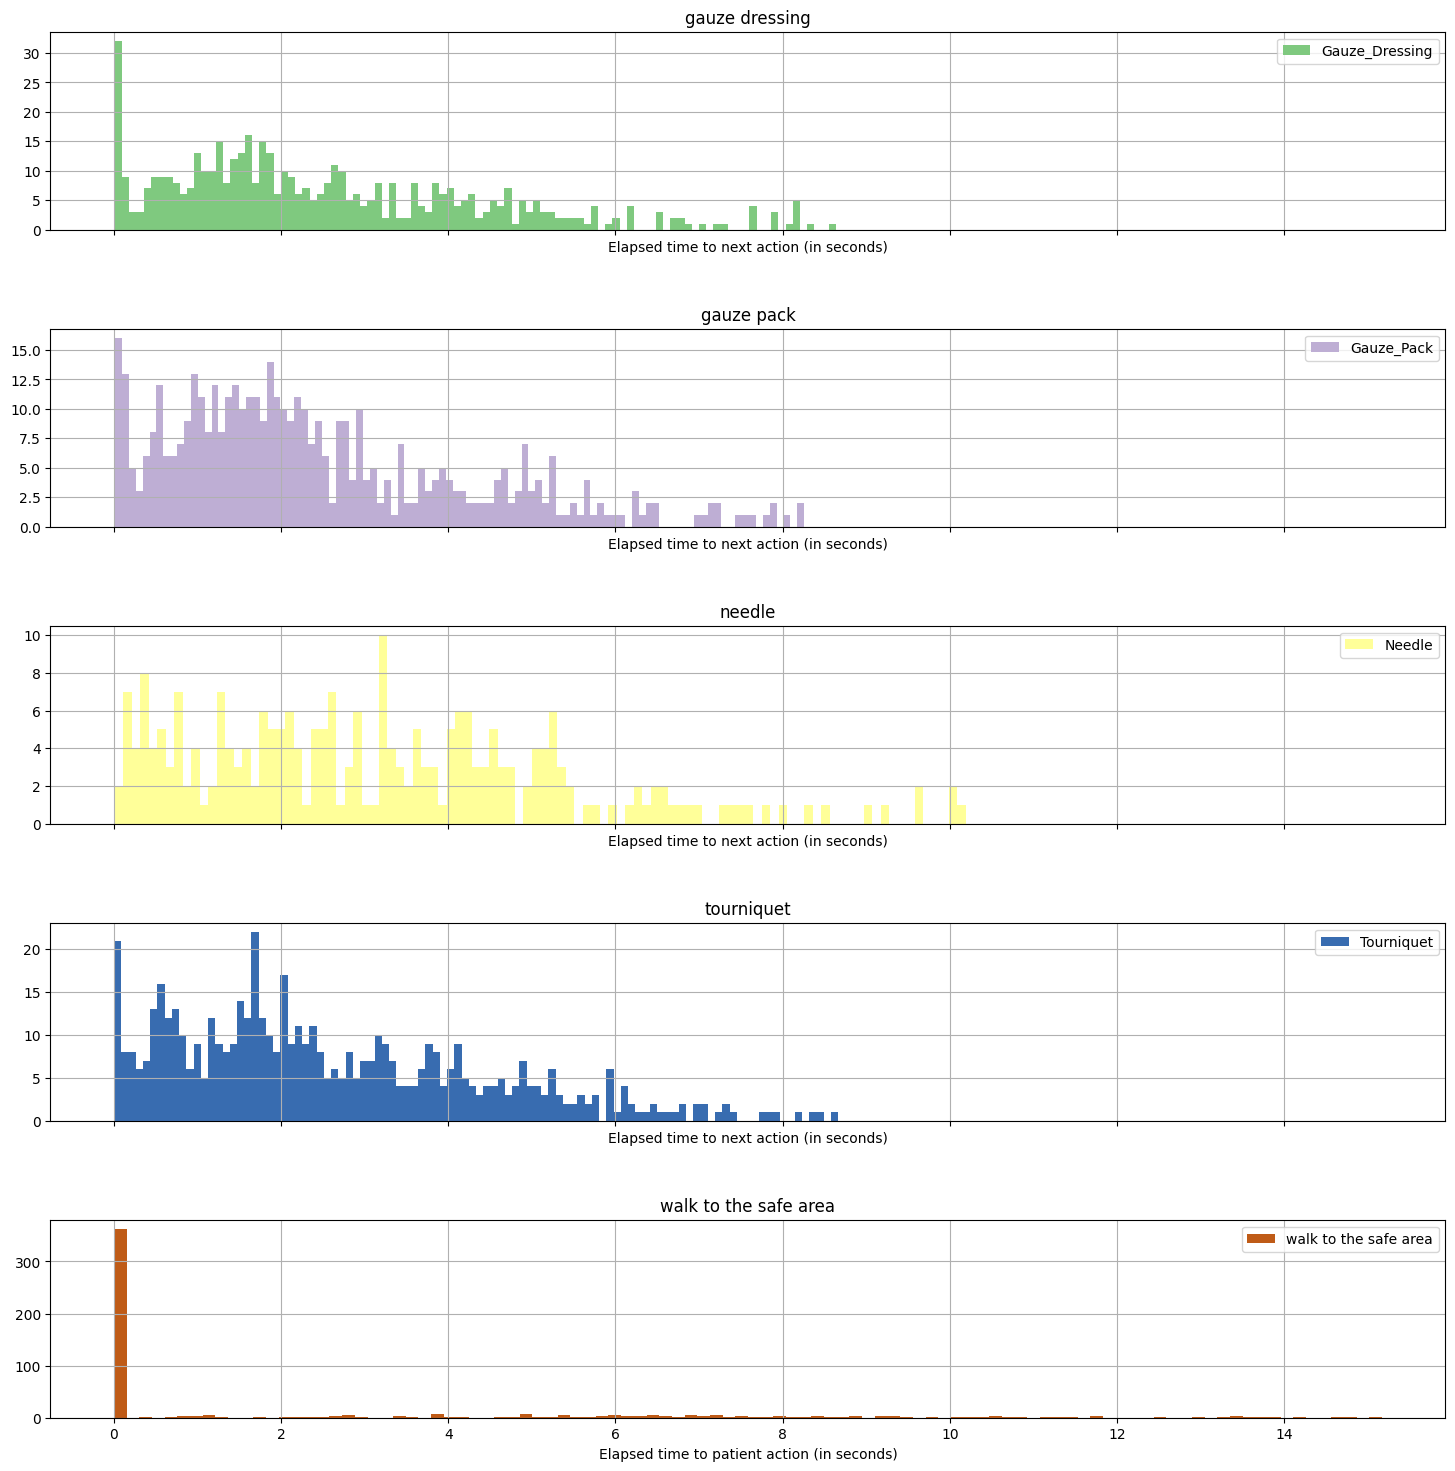

In [22]:

list_length = len(tuples_list)
color_cycler = nu.get_color_cycler(list_length)
fig, axes = plt.subplots(nrows=list_length-1, sharex=True, figsize=(18, 18))
for (i, percentiles_tuple), face_color_dict in zip(enumerate(tuples_list), color_cycler()):
    face_color = face_color_dict['color']
    if i < list_length-1:
        percentiles_tuple[0].hist(ax=axes[i], bins=100, label=percentiles_tuple[1], alpha=1.0, color=face_color)
        axes[i].set_title(percentiles_tuple[1].lower().replace('_', ' '))
    
        # Label the x axis for the plots differently
        if percentiles_tuple[1] in ['walk to the safe area', 'wave if you can']:
            axes[i].set_xlabel('Elapsed time to patient action (in seconds)')
        else:
            axes[i].set_xlabel('Elapsed time to next action (in seconds)')
        
        axes[i].legend()

# Add a larger vertical gap between the plots
plt.subplots_adjust(hspace=0.5)

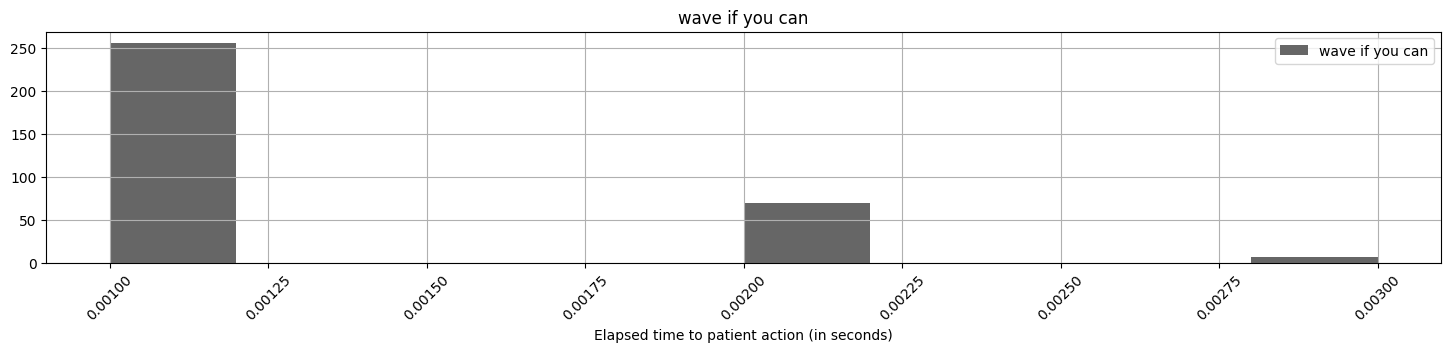

In [23]:

fig, ax = plt.subplots(nrows=1, sharex=True, figsize=(18, 18/6))
tuples_list[-1][0].hist(ax=ax, xrot=45, label=tuples_list[-1][1], alpha=1.0, color=face_color);
ax.set_title(tuples_list[-1][1].lower().replace('_', ' '))

# Label the x axis for the plots differently
ax.set_xlabel('Elapsed time to patient action (in seconds)')

ax.legend();

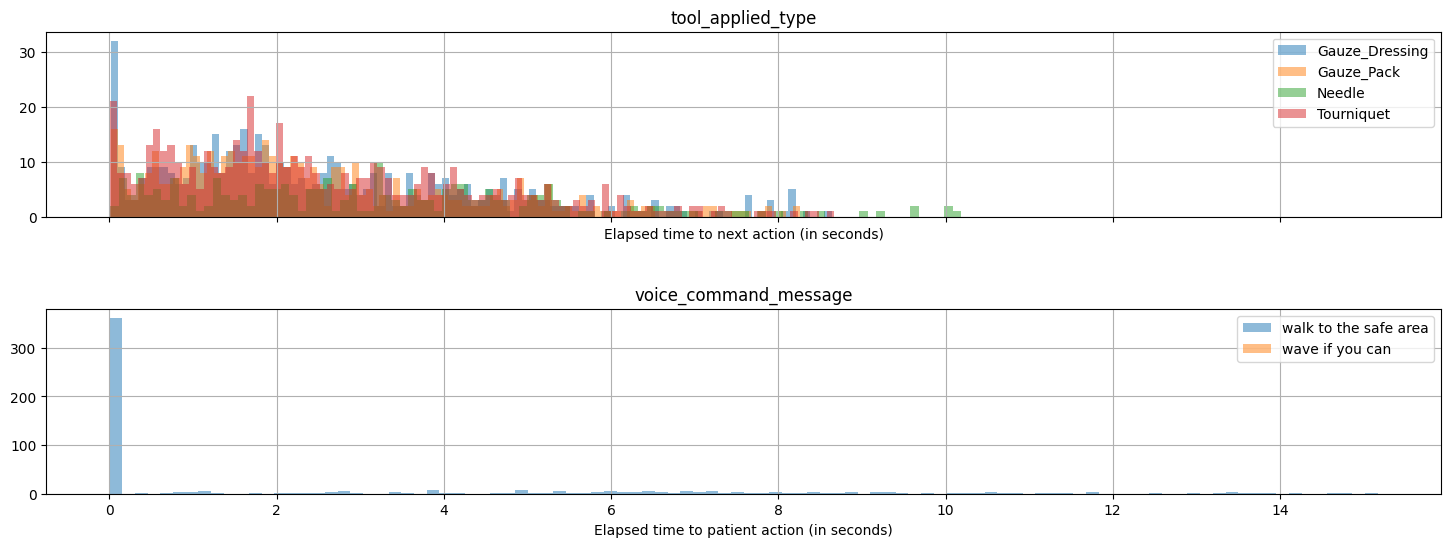

In [152]:

mask_series = ~clean_csvs_df.delta_to_next_action.isnull()
df = clean_csvs_df[mask_series]
# print(df.shape)
# display(df.sample(4).dropna(axis='columns', how='all').T)
fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(18, 6))
for i, groupby_list in enumerate(['tool_applied_type', 'voice_command_message']):
    for tool_applied_type, df1 in df.groupby(groupby_list):

        # Filter to only keep values within 1.75 * Inter quartile range
        q1 = df1.delta_to_next_action.quantile(0.25)
        q3 = df1.delta_to_next_action.quantile(0.75)
        iqr = q3 - q1
        lower_range = q1 - 1.75 * iqr
        higher_range = q3 + 1.75 * iqr
        mask_series = df1.delta_to_next_action.between(lower_range, higher_range) & ~df1.delta_to_next_action.isnull()
        df_filtered = df1[mask_series]
        
        df_filtered.delta_to_next_action.map(lambda td: td.total_seconds()).hist(ax=axes[i], bins=100, label=tool_applied_type, alpha=0.5)
    axes[i].set_title(groupby_list)
    # axes[i].set_xlim(-1_000, 20_000)

    # Label the x axis for the plots differently
    if i == 1:
        axes[i].set_xlabel('Elapsed time to patient action (in seconds)')
    else:
        axes[i].set_xlabel('Elapsed time to next action (in seconds)')
    
    axes[i].legend()

# Add a larger vertical gap between the plots
plt.subplots_adjust(hspace=0.5)


----

In [56]:

action_type = 'INJURY_TREATED'
mask_series = (clean_csvs_df.action_type == action_type)
df = clean_csvs_df[mask_series].sample(4).dropna(axis='columns', how='all')
display(df.T)

,125553,54003,132594,117404
action_type,INJURY_TREATED,INJURY_TREATED,INJURY_TREATED,INJURY_TREATED
elapsed_time,180555,572298,592168,811764
event_time,2023-05-31 09:48:00,2023-05-31 09:24:00,2023-04-21 09:50:00,2023-05-09 09:55:00
session_uuid,e96d123b-455b-4335-9278-988ff9ba8ecf,14a344df-eee2-4fd1-b182-e3cdacd9026c,f68ce2b4-67dc-4829-89fc-cfe478391148,d347b967-5e20-4527-95dd-3a0fdf73af1d
file_name,e96d123b-455b-4335-9278-988ff9ba8ecf,14a344df-eee2-4fd1-b182-e3cdacd9026c,max11,d347b967-5e20-4527-95dd-3a0fdf73af1d
time_group,1,2,2,2
injury_treated_id,L Thigh Laceration,R Shin Amputation,R Thigh Laceration,L Forearm Laceration
injury_treated_patient_id,Mike_1 Root,Lily_2 Root,Mike_5 Root,Gloria_8 Root
injury_treated_required_procedure,tourniquet,tourniquet,tourniquet,gauzePressure
injury_treated_severity,medium,high,medium,low


In [20]:

f = lambda x: 'air' in str(x).lower()
srs = clean_csvs_df.applymap(f, na_action='ignore').sum()
mask_series = (srs != 0)
columns_list = srs[mask_series].index.tolist()
if columns_list:
    mask_series = False
    for cn in columns_list:
        mask_series |= clean_csvs_df[cn].map(f)
    df = clean_csvs_df[mask_series].sample(4).dropna(axis='columns', how='all')
    display(df.T)

,29547,57711,10844,123629
action_type,INJURY_RECORD,INJURY_RECORD,INJURY_RECORD,INJURY_RECORD
elapsed_time,189166,25956,40233,256710
event_time,2023-03-07 10:19:00,2023-06-08 10:31:00,2023-05-22 20:23:00,2023-06-23 09:45:00
session_uuid,33e7d6b6-2868-42e6-8967-d6890efb87a7,2be0000b-9e0b-414f-a540-c495ffc28404,5fa79a8e-a2df-4bb9-b614-f3ce36a5edb0,e0b7bea0-1cf9-42a8-a02c-e8699a962779
file_name,Marty11,2be0000b-9e0b-414f-a540-c495ffc28404,5fa79a8e-a2df-4bb9-b614-f3ce36a5edb0,e0b7bea0-1cf9-42a8-a02c-e8699a962779
time_group,2,1,1,1
injury_record_id,Face Shrapnel,Face Shrapnel,Face Shrapnel,Face Shrapnel
injury_record_patient_id,Bob_0 Root,Gary_1 Root,Helga_17 Root,Bob_0 Root
injury_record_required_procedure,airway,airway,airway,airway
injury_record_severity,high,high,high,high


In [19]:

nasal_regex = re.compile(r'nas(a|o)')
f = lambda x: bool(nasal_regex.search(str(x)))
srs = clean_csvs_df.applymap(f, na_action='ignore').sum()
mask_series = (srs != 0)
columns_list = srs[mask_series].index.tolist()
if columns_list:
    mask_series = False
    for cn in columns_list:
        mask_series |= clean_csvs_df[cn].map(f)
    df = clean_csvs_df[mask_series].sample(4).dropna(axis='columns', how='all')
    display(df.T)

In [11]:

mask_series = (clean_csvs_df.action_type == 'VOICE_COMMAND') & clean_csvs_df.voice_command_message.map(lambda x: 'wave' in str(x).lower())
print(clean_csvs_df[mask_series].shape)
df = clean_csvs_df[mask_series].sample(4).dropna(axis='columns', how='all')
display(df.T)

(566, 100)


,27449,80204,58693,104702
action_type,VOICE_COMMAND,VOICE_COMMAND,VOICE_COMMAND,VOICE_COMMAND
elapsed_time,522330,28430,233248,41162
event_time,2023-03-03 10:31:00,2023-05-11 10:32:00,2023-06-23 10:42:00,2023-05-10 11:06:00
session_uuid,e662a811-40fd-4bf2-b9df-d2d221d07b4a,8581c1f8-a4e8-4245-ac73-2bd671237001,2d920452-cfa3-41f4-95de-36b62a023900,a1cb9dd5-e62b-4085-99d8-688e0a3856ee
file_name,Marty1,8581c1f8-a4e8-4245-ac73-2bd671237001,2d920452-cfa3-41f4-95de-36b62a023900,a1cb9dd5-e62b-4085-99d8-688e0a3856ee
time_group,2,1,2,1
voice_command_message,wave if you can,wave if you can,wave if you can,wave if you can
voice_command_command_description,wave,wave,wave,good American wave wave your arms


In [8]:

mask_series = (clean_csvs_df.action_type == 'TOOL_APPLIED') & clean_csvs_df.tool_applied_type.map(lambda x: 'gauze' in str(x).lower())
print(clean_csvs_df[mask_series].shape)
df = clean_csvs_df[mask_series].sample(4).dropna(axis='columns', how='all')
display(df.T)

(994, 100)


,116804,95189,30685,68483
action_type,TOOL_APPLIED,TOOL_APPLIED,TOOL_APPLIED,TOOL_APPLIED
elapsed_time,302503,1444969,544301,443993
event_time,2023-05-09 09:47:00,2023-05-09 08:34:00,2023-03-07 10:37:00,2023-05-09 08:48:00
session_uuid,d347b967-5e20-4527-95dd-3a0fdf73af1d,9d142377-69d6-4622-958d-a29a6a0a0d21,400b6351-6f35-4f5b-98a6-db100a2fefd8,5aca0157-02d0-4409-a4fe-f64d03fd34a1
file_name,d347b967-5e20-4527-95dd-3a0fdf73af1d,9d142377-69d6-4622-958d-a29a6a0a0d21,Marty12,5aca0157-02d0-4409-a4fe-f64d03fd34a1
time_group,1,3,2,2
tool_applied_type,Gauze_Dressing,Gauze_Pack,Gauze_Dressing,Gauze_Dressing
tool_applied_attachment_point,skinCollider_BodyCollideLOD (UnityEngine.GameO...,skinCollider_BodyCollideLOD (UnityEngine.GameO...,skinCollider_Body_LOD (UnityEngine.GameObject),skinCollider_Body_LOD (UnityEngine.GameObject)
tool_applied_sender,AppliedDressingGauze,AppliedPackingGauze,AppliedDressingGauze,AppliedDressingGauze
tool_applied_patient_id,Mike_0 Root,Mike_5 Root,Gloria_6 Root,Gloria_8 Root


In [26]:

# Get the last previous tool hover for each patient engaged
if nu.pickle_exists('hover_engage_df'):
    hover_engage_df = nu.load_object('hover_engage_df')
else:
    import numpy as np
    
    rows_list = []
    for (session_uuid, time_group), df in get_session_groupby(mask_series=None, extra_column='time_group'):
        hover_mask_series = (df.action_type == 'TOOL_HOVER')
        for row_index, row_series in df[hover_mask_series].iterrows():
            hover_elapsed_time = row_series.elapsed_time
            engage_mask_series = (df.elapsed_time >= hover_elapsed_time) & ~df.patient_id.isnull()
            if df[engage_mask_series].shape[0]:
    
                # Get the patient's ID
                engage_elapsed_time = df[engage_mask_series].elapsed_time.min()
                patient_mask_series = (df.elapsed_time == engage_elapsed_time) & ~df.patient_id.isnull()
                patient_id = df[patient_mask_series].iloc[0].patient_id
    
                # Get the required procedure
                require_mask_series = (df.patient_id == patient_id) & ~df.injury_record_required_procedure.isnull()
                if df[require_mask_series].shape[0]:
                    injury_record_required_procedure = nu.conjunctify_nouns(df[require_mask_series].injury_record_required_procedure.tolist())
                else:
                    injury_record_required_procedure = np.nan
    
                # Get what tool the DM is looking at
                tool_hover_type = row_series.tool_hover_type
    
                # Add that info to the data frame
                row_dict = {
                    'session_uuid': session_uuid, 'time_group': time_group, 'tool_hover_type': tool_hover_type,
                    'injury_record_required_procedure': injury_record_required_procedure, 'patient_id': patient_id
                }
                rows_list.append(row_dict)
                
    hover_engage_df = DataFrame(rows_list).drop_duplicates(subset=['session_uuid', 'time_group', 'patient_id'], keep='last')
    
    # Get the last previous tool hover for each patient engaged
    def f(row_series):
        tool_hover_type = str(row_series.tool_hover_type)
        injury_record_required_procedure = str(row_series.injury_record_required_procedure)
        
        if (tool_hover_type.lower() in injury_record_required_procedure):
            similarity = 1.0
        elif (tool_hover_type == 'Tourniquet') and ('tourniquet' not in injury_record_required_procedure):
            similarity = 0.0
        elif (tool_hover_type == 'Hemostatic Gauze') and ('woundpack' in injury_record_required_procedure):
            similarity = 1.0
        elif (tool_hover_type == 'Hemostatic Gauze') and ('woundpack' not in injury_record_required_procedure):
            similarity = 0.0
        elif (tool_hover_type == 'Gauze') and ('gauzePressure' in injury_record_required_procedure):
            similarity = 1.0
        elif (tool_hover_type == 'Gauze') and ('gauzePressure' not in injury_record_required_procedure):
            similarity = 0.0
        elif (tool_hover_type == 'Needle') and ('airway' in injury_record_required_procedure):
            similarity = 1.0
        elif (tool_hover_type == 'Needle') and ('airway' not in injury_record_required_procedure):
            similarity = 0.0
        elif (tool_hover_type != 'NaN') and (injury_record_required_procedure in ['none', 'NaN']):
            similarity = 0.0
        elif (injury_record_required_procedure in ['none', 'NaN']):
            similarity = 1.0
        else:
            similarity = nu.similar(tool_hover_type, injury_record_required_procedure)
        
        return similarity
    hover_engage_df['similarity'] = hover_engage_df.apply(f, axis='columns')

    # Store the data frame as a pickle
    nu.store_objects(hover_engage_df=hover_engage_df)

In [42]:

percent_accuracy = 100*hover_engage_df.similarity.sum()/hover_engage_df.similarity.shape[0]
print(f'The last previous tool hover correctly anticipates the required injury procedure for each patient engaged {percent_accuracy:.1f}% of the time.')

The last previous tool hover correctly anticipates the required injury procedure for each patient engaged 65.5% of the time.
